# # Network_Threat_Analysis_System
# ## Comprehensive Feature Extraction and Machine Learning Framework
# 
# This notebook integrates three analysis approaches:
# 1. Statistical flow analysis
# 2. Semantic content analysis  
# 3. Visual pattern generation
#
# Output includes both human-readable reports and ML-ready datasets.


# ### Step 1: Environment Setup and Dependency Installation

In [ ]:
# Cell 1: Environment Setup and Dependencies
"""
Install and import all required packages for the analysis pipeline
"""

import subprocess
import sys
import os
import time
import json
import warnings
import gc
import re
import math
import statistics
import hashlib
import ipaddress
import string
import urllib.parse
import base64
from datetime import datetime
from pathlib import Path
from collections import defaultdict, Counter
from html.parser import HTMLParser

# Data processing libraries
import numpy as np
import pandas as pd
import h5py

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Network analysis libraries
from scapy.all import PcapReader, IP, TCP, UDP, ICMP, Raw, DNS, rdpcap
import psutil
import tldextract
import networkx as nx

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb
import joblib

# Progress tracking
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

warnings.filterwarnings('ignore')
print("All libraries imported successfully")


All libraries imported successfully


# ### Step 2: Configuration Interface

In [ ]:
# Cell 2: Configuration Interface
"""
Interactive configuration for the analysis pipeline
Users can specify file paths and analysis options here
"""

class ConfigurationManager:
    def __init__(self):
        self.config = {}
        self.setup_ui()
    
    def setup_ui(self):
        """Create interactive UI elements for configuration"""
        
        # File input widgets
        self.pcap_input = widgets.Text(
            placeholder='Enter full path to PCAP file',
            description='PCAP File:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='700px')
        )
        
        self.output_dir = widgets.Text(
            placeholder='Enter output directory path',
            description='Output Dir:',
            value='./cicids_analysis_output',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='700px')
        )
        
        # Analysis mode selection
        self.analysis_mode = widgets.RadioButtons(
            options=['Flow Analysis Only', 'Semantic Analysis Only', 'Combined Analysis'],
            value='Combined Analysis',
            description='Analysis Type:',
            style={'description_width': 'initial'}
        )
        
        # Deep inspection option
        self.deep_inspection = widgets.Checkbox(
            value=True,
            description='Enable Deep Packet Inspection (slower but more thorough)',
            indent=False,
            layout=widgets.Layout(width='400px')
        )
        
        # Visualization option
        self.generate_visuals = widgets.Checkbox(
            value=True,
            description='Generate Visualizations',
            indent=False
        )
        
        # Chunk size for memory management
        self.chunk_size = widgets.IntSlider(
            value=10000,
            min=1000,
            max=100000,
            step=1000,
            description='Chunk Size:',
            tooltip='Number of packets to process before memory cleanup',
            style={'description_width': 'initial'}
        )
        
        # ML model selection
        self.ml_approach = widgets.RadioButtons(
            options=['XGBoost', 'LightGBM', 'Ensemble'],
            value='XGBoost',
            description='ML Model:',
            style={'description_width': 'initial'}
        )
        
        # Process button
        self.process_btn = widgets.Button(
            description='Validate Configuration',
            button_style='primary',
            layout=widgets.Layout(width='200px', height='40px')
        )
        self.process_btn.on_click(self.validate_and_save)
        
        # Status output
        self.status_output = widgets.Output()
        
        # Display UI
        display(HTML("<h3>Network Traffic Analysis Configuration</h3>"))
        display(widgets.VBox([
            widgets.HTML("<b>Input/Output Settings:</b>"),
            self.pcap_input,
            self.output_dir,
            widgets.HTML("<br><b>Analysis Options:</b>"),
            self.analysis_mode,
            self.deep_inspection,
            self.generate_visuals,
            self.chunk_size,
            widgets.HTML("<br><b>Machine Learning:</b>"),
            self.ml_approach,
            widgets.HTML("<br>"),
            self.process_btn,
            self.status_output
        ]))
    
    def validate_and_save(self, b):
        """Validate inputs and save configuration"""
        with self.status_output:
            clear_output()
            
            # Validate PCAP file
            if not self.pcap_input.value:
                print("Error: Please enter a PCAP file path")
                return
            
            # Handle quotes in path
            pcap_path = self.pcap_input.value.strip()
            if pcap_path.startswith('"') and pcap_path.endswith('"'):
                pcap_path = pcap_path[1:-1]
            
            if not os.path.exists(pcap_path):
                print(f"Error: PCAP file not found: {pcap_path}")
                return
            
            # Create output directory
            os.makedirs(self.output_dir.value, exist_ok=True)
            
            # Save configuration
            self.config = {
                'pcap_file': pcap_path,
                'output_dir': self.output_dir.value,
                'analysis_mode': self.analysis_mode.value,
                'deep_inspection': self.deep_inspection.value,
                'generate_visuals': self.generate_visuals.value,
                'chunk_size': self.chunk_size.value,
                'ml_approach': self.ml_approach.value
            }
            
            print("Configuration validated successfully!\n")
            print("Configuration Summary:")
            print("-" * 50)
            for key, value in self.config.items():
                print(f"{key}: {value}")
            print("-" * 50)
            
            # Calculate estimated processing time
            file_size_gb = os.path.getsize(self.config['pcap_file']) / (1024**3)
            # Rough estimates based on analysis mode
            if self.config['analysis_mode'] == 'Flow Analysis Only':
                time_per_gb = 60  # seconds
            elif self.config['analysis_mode'] == 'Semantic Analysis Only':
                time_per_gb = 120 if self.config['deep_inspection'] else 80
            else:  # Combined
                time_per_gb = 180 if self.config['deep_inspection'] else 120
            
            estimated_time = file_size_gb * time_per_gb
            
            print(f"\nFile size: {file_size_gb:.2f} GB")
            print(f"Estimated processing time: {estimated_time/60:.1f} minutes")
            
            global CONFIG
            CONFIG = self.config

# Create configuration manager
config_manager = ConfigurationManager()

# ### Step 3:  Flow Feature Extractor Implementation

In [ ]:
# Cell 3: Flow Feature Extractor Implementation
"""
Implementation of the flow-based feature extractor
Extracts statistical features from network flows
"""

class FlowFeatureExtractor:
    """
    Extracts flow-based statistical features from network traffic
    Based on Network_TrafficFlow_Feature_Extractor.py
    """
    
    def __init__(self, chunk_size=10000, enable_visualizations=True):
        self.chunk_size = chunk_size
        self.enable_visualizations = enable_visualizations
        self.flows = defaultdict(self._create_flow_dict)
        self.timeout_seconds = 1800  # 30 minutes
        
        # Feature names for flow analysis
        self.feature_names = [
            'total_packets', 'total_bytes', 'duration', 'packets_per_second',
            'bytes_per_second', 'avg_packet_size', 'flow_direction_ratio',
            'inter_arrival_time_avg', 'tcp_percentage', 'udp_percentage',
            'icmp_percentage', 'fwd_packets_ratio', 'bwd_packets_ratio',
            'packet_size_variance', 'iat_variance', 'active_periods_count',
            'idle_periods_count', 'max_packet_size', 'min_packet_size',
            'flow_bytes_per_sec', 'syn_flag_count', 'fin_flag_count',
            'rst_flag_count', 'ack_flag_count', 'avg_fwd_packet_size',
            'avg_bwd_packet_size', 'fwd_iat_mean', 'bwd_iat_mean'
        ]
        
        # Performance tracking
        self.last_cleanup_time = 0
        self.packets_processed = 0
        
    def _create_flow_dict(self):
        """Create a new flow dictionary with default values"""
        return {
            'src_ip': '', 'dst_ip': '', 'src_port': 0, 'dst_port': 0,
            'protocol': '', 'start_time': 0, 'end_time': 0, 'duration': 0,
            'last_packet_time': 0, 'fwd_packets': 0, 'bwd_packets': 0,
            'fwd_bytes': 0, 'bwd_bytes': 0, 'fwd_packet_sizes': [],
            'bwd_packet_sizes': [], 'fwd_iat': [], 'bwd_iat': [],
            'fin_flags': 0, 'syn_flags': 0, 'rst_flags': 0, 'psh_flags': 0,
            'ack_flags': 0, 'urg_flags': 0, 'ece_flags': 0, 'cwr_flags': 0,
            'active_periods': [], 'idle_periods': []
        }
    
    def get_flow_key(self, packet):
        """Generate a unique flow key from packet"""
        if not packet.haslayer(IP):
            return None
        
        try:
            ip_layer = packet[IP]
            src_ip = str(ip_layer.src)
            dst_ip = str(ip_layer.dst)
            protocol = int(ip_layer.proto)
            
            src_port = dst_port = 0
            if packet.haslayer(TCP):
                src_port = int(packet[TCP].sport)
                dst_port = int(packet[TCP].dport)
            elif packet.haslayer(UDP):
                src_port = int(packet[UDP].sport)
                dst_port = int(packet[UDP].dport)
            
            # Create bidirectional flow key
            flow_tuple = tuple(sorted([(src_ip, src_port), (dst_ip, dst_port)]))
            return (*flow_tuple[0], *flow_tuple[1], protocol)
            
        except Exception:
            return None
    
    def process_packet(self, packet, packet_time):
        """Process a single packet and update flow statistics"""
        flow_key = self.get_flow_key(packet)
        if not flow_key:
            return
        
        flow = self.flows[flow_key]
        
        # Initialize flow on first packet
        if flow['start_time'] == 0:
            flow['start_time'] = packet_time
            if packet.haslayer(IP):
                flow['src_ip'] = str(packet[IP].src)
                flow['dst_ip'] = str(packet[IP].dst)
            
            if packet.haslayer(TCP):
                flow['src_port'] = int(packet[TCP].sport)
                flow['dst_port'] = int(packet[TCP].dport)
                flow['protocol'] = 'TCP'
            elif packet.haslayer(UDP):
                flow['src_port'] = int(packet[UDP].sport)
                flow['dst_port'] = int(packet[UDP].dport)
                flow['protocol'] = 'UDP'
            else:
                flow['protocol'] = 'OTHER'
        
        # Update flow timing
        flow['end_time'] = packet_time
        flow['duration'] = packet_time - flow['start_time']
        
        # Determine packet direction
        is_forward = (packet.haslayer(IP) and str(packet[IP].src) == flow['src_ip'])
        packet_size = len(packet)
        
        if is_forward:
            flow['fwd_packets'] += 1
            flow['fwd_bytes'] += packet_size
            flow['fwd_packet_sizes'].append(packet_size)
            if flow['last_packet_time'] > 0:
                iat = packet_time - flow['last_packet_time']
                flow['fwd_iat'].append(iat)
        else:
            flow['bwd_packets'] += 1
            flow['bwd_bytes'] += packet_size
            flow['bwd_packet_sizes'].append(packet_size)
            if flow['last_packet_time'] > 0:
                iat = packet_time - flow['last_packet_time']
                flow['bwd_iat'].append(iat)
        
        flow['last_packet_time'] = packet_time
        
        # Extract TCP flags if present
        if packet.haslayer(TCP):
            tcp_flags = packet[TCP].flags
            if tcp_flags & 0x01: flow['fin_flags'] += 1
            if tcp_flags & 0x02: flow['syn_flags'] += 1
            if tcp_flags & 0x04: flow['rst_flags'] += 1
            if tcp_flags & 0x08: flow['psh_flags'] += 1
            if tcp_flags & 0x10: flow['ack_flags'] += 1
            if tcp_flags & 0x20: flow['urg_flags'] += 1
        
        self.packets_processed += 1
    
    def cleanup_old_flows(self, current_time):
        """Remove expired flows to manage memory"""
        if current_time - self.last_cleanup_time < 300:
            return
        
        self.last_cleanup_time = current_time
        timeout_threshold = current_time - self.timeout_seconds
        
        expired_flows = [
            flow_key for flow_key, flow in self.flows.items()
            if flow['end_time'] < timeout_threshold
        ]
        
        for flow_key in expired_flows:
            del self.flows[flow_key]
        
        if len(expired_flows) > 1000:
            gc.collect()
    
    def extract_features_from_flow(self, flow):
        """Extract statistical features from a single flow"""
        features = []
        
        # Basic statistics
        total_packets = flow['fwd_packets'] + flow['bwd_packets']
        total_bytes = flow['fwd_bytes'] + flow['bwd_bytes']
        duration = max(flow['duration'], 0.000001)
        
        features.extend([
            total_packets,
            total_bytes,
            duration,
            total_packets / duration,
            total_bytes / duration,
            total_bytes / max(total_packets, 1),
            flow['fwd_bytes'] / max(total_bytes, 1),
            np.mean(flow['fwd_iat'] + flow['bwd_iat']) if (flow['fwd_iat'] + flow['bwd_iat']) else 0
        ])
        
        # Protocol distribution
        features.extend([
            1.0 if flow['protocol'] == 'TCP' else 0.0,
            1.0 if flow['protocol'] == 'UDP' else 0.0,
            1.0 if flow['protocol'] == 'ICMP' else 0.0,
            flow['fwd_packets'] / max(total_packets, 1),
            flow['bwd_packets'] / max(total_packets, 1)
        ])
        
        # Temporal patterns
        all_packet_sizes = flow['fwd_packet_sizes'] + flow['bwd_packet_sizes']
        all_iats = flow['fwd_iat'] + flow['bwd_iat']
        
        features.extend([
            np.var(all_packet_sizes) if all_packet_sizes else 0,
            np.var(all_iats) if all_iats else 0,
            len(flow['active_periods']),
            len(flow['idle_periods']),
            max(all_packet_sizes) if all_packet_sizes else 0,
            min(all_packet_sizes) if all_packet_sizes else 0,
            total_bytes / duration
        ])
        
        # Flag counts
        features.extend([
            flow['syn_flags'],
            flow['fin_flags'],
            flow['rst_flags'],
            flow['ack_flags'],
            np.mean(flow['fwd_packet_sizes']) if flow['fwd_packet_sizes'] else 0,
            np.mean(flow['bwd_packet_sizes']) if flow['bwd_packet_sizes'] else 0,
            np.mean(flow['fwd_iat']) if flow['fwd_iat'] else 0,
            np.mean(flow['bwd_iat']) if flow['bwd_iat'] else 0
        ])
        
        return features
    
    def process_pcap_file(self, pcap_file_path, progress_callback=None):
        """Process PCAP file and extract flow features"""
        
        print(f"Starting flow feature extraction from: {pcap_file_path}")
        file_size_gb = os.path.getsize(pcap_file_path) / (1024**3)
        print(f"File size: {file_size_gb:.2f} GB")
        
        packet_count = 0
        chunk_count = 0
        start_time = time.time()
        
        try:
            with PcapReader(pcap_file_path) as pcap_reader:
                for packet in tqdm(pcap_reader, desc="Processing packets", unit="packets"):
                    try:
                        packet_time = float(packet.time)
                        self.process_packet(packet, packet_time)
                        
                        packet_count += 1
                        
                        # Periodic maintenance
                        if packet_count % self.chunk_size == 0:
                            chunk_count += 1
                            self.cleanup_old_flows(packet_time)
                            
                            if progress_callback:
                                progress_callback(packet_count, chunk_count)
                            
                            # Memory management
                            memory_mb = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
                            if memory_mb > 4000:
                                gc.collect()
                    
                    except Exception as e:
                        continue
        
        except Exception as e:
            print(f"Error reading PCAP file: {str(e)}")
            raise
        
        # Extract features from all flows
        print(f"Extracting features from {len(self.flows)} flows...")
        
        feature_matrix = []
        flow_metadata = []
        
        for flow_key, flow in tqdm(self.flows.items(), desc="Extracting flow features"):
            try:
                features = self.extract_features_from_flow(flow)
                feature_matrix.append(features)
                
                flow_metadata.append({
                    'src_ip': flow['src_ip'],
                    'dst_ip': flow['dst_ip'],
                    'src_port': flow['src_port'],
                    'dst_port': flow['dst_port'],
                    'protocol': flow['protocol'],
                    'duration': flow['duration'],
                    'total_packets': flow['fwd_packets'] + flow['bwd_packets'],
                    'total_bytes': flow['fwd_bytes'] + flow['bwd_bytes']
                })
            except Exception:
                continue
        
        # Create DataFrame
        df_features = pd.DataFrame(feature_matrix, columns=self.feature_names)
        df_metadata = pd.DataFrame(flow_metadata)
        result_df = pd.concat([df_metadata, df_features], axis=1)
        
        processing_time = time.time() - start_time
        print(f"Flow extraction completed in {processing_time:.2f} seconds")
        print(f"Extracted {len(result_df)} flows from {packet_count} packets")
        
        return result_df

# ### Step4: Semantic Feature Extractor Implementation

In [ ]:
# Cell 4: Semantic Feature Extractor Implementation
"""
Implementation of the semantic content analyzer
Performs deep inspection of packet payloads
"""

class SemanticFeatureExtractor:
    """
    Extracts semantic features from packet payloads
    Based on Network_Semantic_Feature_Extractor.py
    """
    
    def __init__(self, chunk_size=10000, deep_inspection=True):
        self.chunk_size = chunk_size
        self.deep_inspection = deep_inspection
        self.flows = defaultdict(self._create_semantic_flow_dict)
        
        # Semantic feature names
        self.feature_names = [
            'domain_entropy', 'subdomain_count', 'suspicious_keywords',
            'domain_age_category', 'url_length', 'special_char_ratio',
            'numeric_ratio', 'tld_reputation', 'query_entropy',
            'dga_probability', 'query_frequency', 'unique_domains',
            'failed_queries', 'subdomain_entropy', 'user_agent_entropy',
            'header_anomalies', 'content_type_variety', 'status_code_distribution',
            'referrer_consistency', 'cookie_complexity', 'command_keywords',
            'obfuscation_indicators', 'script_language_mix', 'dangerous_functions',
            'encryption_indicators', 'redirect_frequency', 'https_ratio',
            'path_depth', 'param_complexity', 'host_diversity',
            'mime_type_entropy', 'certificate_validity', 'semantic_consistency'
        ]
        
        # Initialize threat detection patterns
        self.command_keywords = {
            'select', 'insert', 'update', 'delete', 'exec', 'shell', 'cmd',
            'powershell', 'bash', 'wget', 'curl', 'chmod', 'system', 'eval'
        }
        
        self.suspicious_url_keywords = {
            'high': ['admin', 'login', 'banking', 'verify', 'secure', 'password'],
            'medium': ['payment', 'credit', 'bank', 'paypal', 'ebay', 'amazon'],
            'low': ['download', 'free', 'prize', 'winner', 'offer', 'gift']
        }
        
        self.tld_reputation = self._initialize_tld_reputation()
        self.packets_processed = 0
        
    def _create_semantic_flow_dict(self):
        """Create flow dictionary for semantic analysis"""
        return {
            'src_ip': '', 'dst_ip': '', 'src_port': 0, 'dst_port': 0,
            'protocol': '', 'start_time': 0, 'end_time': 0, 'duration': 0,
            'http_requests': [], 'http_responses': [], 'urls_requested': [],
            'user_agents': [], 'content_types': [], 'status_codes': [],
            'dns_queries': [], 'dns_responses': [], 'unique_domains': set(),
            'failed_queries': 0, 'command_keywords_detected': set(),
            'obfuscation_indicators': 0, 'encryption_indicators': 0,
            'domain_entropy_values': [], 'url_length_values': [],
            'suspicious_keywords_count': 0, 'suspicious_tld_count': 0
        }
    
    def _initialize_tld_reputation(self):
        """Initialize TLD reputation scores"""
        reputation = defaultdict(lambda: 0.5)
        
        # Legitimate TLDs
        for tld in ['com', 'org', 'net', 'edu', 'gov', 'mil']:
            reputation[tld] = 0.9
        
        # Suspicious TLDs
        for tld in ['tk', 'ml', 'ga', 'cf', 'xyz', 'top', 'pw']:
            reputation[tld] = 0.2
        
        return reputation
    
    def _calculate_entropy(self, data):
        """Calculate Shannon entropy of data"""
        if not data:
            return 0
        
        if isinstance(data, str):
            data = data.encode('utf-8', errors='ignore')
        
        byte_counts = Counter(data)
        data_len = len(data)
        
        entropy = 0
        for count in byte_counts.values():
            probability = count / data_len
            entropy -= probability * math.log2(probability)
        
        return entropy
    
    def _analyze_url(self, url, flow):
        """Analyze URL for suspicious patterns"""
        try:
            parsed = urllib.parse.urlparse(url)
            extracted = tldextract.extract(parsed.netloc or parsed.path)
            
            domain = extracted.domain
            tld = extracted.suffix
            subdomain = extracted.subdomain
            
            # Check TLD reputation
            if tld in self.tld_reputation:
                if self.tld_reputation[tld] < 0.5:
                    flow['suspicious_tld_count'] += 1
            
            # Calculate domain entropy
            if domain:
                entropy = self._calculate_entropy(domain)
                flow['domain_entropy_values'].append(entropy)
            
            # Check URL length
            flow['url_length_values'].append(len(url))
            
            # Check for suspicious keywords
            url_lower = url.lower()
            for severity, keywords in self.suspicious_url_keywords.items():
                for keyword in keywords:
                    if keyword in url_lower:
                        if severity == 'high':
                            flow['suspicious_keywords_count'] += 3
                        elif severity == 'medium':
                            flow['suspicious_keywords_count'] += 2
                        else:
                            flow['suspicious_keywords_count'] += 1
            
        except Exception:
            pass
    
    def _analyze_payload(self, payload_text, flow):
        """Analyze payload for malicious patterns"""
        if not payload_text:
            return
        
        # Check for command keywords
        for cmd in self.command_keywords:
            if re.search(r'\b' + re.escape(cmd) + r'\b', payload_text, re.IGNORECASE):
                flow['command_keywords_detected'].add(cmd)
        
        # Check for base64 encoding
        base64_pattern = r'[A-Za-z0-9+/]{20,}={0,2}'
        base64_matches = re.findall(base64_pattern, payload_text)
        if base64_matches:
            flow['obfuscation_indicators'] += len(base64_matches)
        
        # Check entropy for encryption
        entropy = self._calculate_entropy(payload_text)
        if entropy > 7.0:
            flow['encryption_indicators'] += 1
    
    def process_packet_semantic(self, packet, packet_time, flow_key):
        """Process packet for semantic features"""
        if not packet.haslayer(Raw):
            return
        
        flow = self.flows[flow_key]
        
        # Initialize flow timing
        if flow['start_time'] == 0:
            flow['start_time'] = packet_time
            if packet.haslayer(IP):
                flow['src_ip'] = str(packet[IP].src)
                flow['dst_ip'] = str(packet[IP].dst)
        
        flow['end_time'] = packet_time
        flow['duration'] = packet_time - flow['start_time']
        
        # Extract payload
        try:
            payload_bytes = bytes(packet[Raw].load)
            payload_text = payload_bytes.decode('utf-8', errors='ignore')
        except Exception:
            return
        
        # Analyze HTTP traffic
        if packet.haslayer(TCP):
            dst_port = packet[TCP].dport
            
            if dst_port in (80, 8080, 443, 8443):
                # Check for HTTP request
                for method in ('GET', 'POST', 'PUT', 'DELETE', 'HEAD'):
                    if payload_text.startswith(method + ' '):
                        # Extract URL
                        url_match = re.search(f"{method} (.*?) HTTP", payload_text)
                        if url_match:
                            url = url_match.group(1).strip()
                            flow['urls_requested'].append(url)
                            self._analyze_url(url, flow)
                        
                        # Extract User-Agent
                        ua_match = re.search(r"User-Agent: (.*?)[\r\n]", payload_text)
                        if ua_match:
                            flow['user_agents'].append(ua_match.group(1).strip())
                        
                        break
                
                # Check for HTTP response
                if payload_text.startswith('HTTP/'):
                    status_match = re.search(r"HTTP/[\d\.]+ (\d+)", payload_text)
                    if status_match:
                        flow['status_codes'].append(int(status_match.group(1)))
        
        # Analyze DNS traffic
        if packet.haslayer(UDP) and packet[UDP].dport == 53:
            if packet.haslayer(DNS):
                dns = packet[DNS]
                if dns.qr == 0 and dns.qd:  # DNS query
                    try:
                        qname = dns.qd.qname.decode('utf-8', errors='ignore')
                        flow['dns_queries'].append(qname)
                        flow['unique_domains'].add(qname)
                    except Exception:
                        pass
        
        # Analyze payload for threats
        if self.deep_inspection:
            self._analyze_payload(payload_text, flow)
        
        self.packets_processed += 1
    
    def extract_semantic_features_from_flow(self, flow):
        """Extract semantic features from flow"""
        features = []
        
        # URL Analysis Features
        avg_domain_entropy = np.mean(flow['domain_entropy_values']) if flow['domain_entropy_values'] else 0
        features.append(avg_domain_entropy)
        
        subdomain_count = 0  # Simplified
        features.append(subdomain_count)
        
        features.append(flow.get('suspicious_keywords_count', 0))
        features.append(0.5)  # domain_age_category - placeholder
        
        avg_url_length = np.mean(flow['url_length_values']) if flow['url_length_values'] else 0
        features.append(avg_url_length)
        
        # Calculate special character ratio
        special_char_ratio = 0.1
        if flow['urls_requested']:
            total_chars = sum(len(url) for url in flow['urls_requested'])
            special_chars = sum(1 for url in flow['urls_requested'] 
                              for c in url if not c.isalnum() and c not in '/:.-_')
            if total_chars > 0:
                special_char_ratio = special_chars / total_chars
        features.append(special_char_ratio)
        
        # Calculate numeric ratio
        numeric_ratio = 0.05
        if flow['urls_requested']:
            total_chars = sum(len(url) for url in flow['urls_requested'])
            numeric_chars = sum(1 for url in flow['urls_requested'] for c in url if c.isdigit())
            if total_chars > 0:
                numeric_ratio = numeric_chars / total_chars
        features.append(numeric_ratio)
        
        features.append(0.7)  # tld_reputation - simplified
        
        # DNS Query Features
        query_entropy = 0
        if flow['dns_queries']:
            entropies = [self._calculate_entropy(q) for q in flow['dns_queries']]
            query_entropy = np.mean(entropies)
        features.append(query_entropy)
        
        # DGA probability calculation
        dga_probability = 0
        if flow['dns_queries']:
            for query in flow['dns_queries']:
                entropy = self._calculate_entropy(query)
                if entropy > 3.5:
                    dga_probability = 0.7
                    break
        features.append(dga_probability)
        
        query_frequency = len(flow['dns_queries']) / max(flow['duration'], 0.1)
        features.append(query_frequency)
        
        features.append(len(flow['unique_domains']))
        features.append(flow.get('failed_queries', 0))
        features.append(0)  # subdomain_entropy - placeholder
        
        # HTTP Content Features
        user_agent_entropy = 0
        if flow['user_agents']:
            ua_entropies = [self._calculate_entropy(ua) for ua in flow['user_agents']]
            user_agent_entropy = np.mean(ua_entropies)
        features.append(user_agent_entropy)
        
        features.append(0)  # header_anomalies - placeholder
        features.append(len(set(flow['content_types'])))  # content_type_variety
        
        # Status code distribution
        status_distribution = 0.5
        if flow['status_codes']:
            error_codes = sum(1 for code in flow['status_codes'] if code >= 400)
            status_distribution = error_codes / len(flow['status_codes'])
        features.append(status_distribution)
        
        features.append(1.0)  # referrer_consistency - placeholder
        features.append(0)  # cookie_complexity - placeholder
        
        # Command & Payload Features
        features.append(len(flow['command_keywords_detected']))
        features.append(flow.get('obfuscation_indicators', 0))
        features.append(0)  # script_language_mix - placeholder
        features.append(0)  # dangerous_functions - placeholder
        features.append(flow.get('encryption_indicators', 0))
        
        # Additional Semantic Features
        redirect_frequency = 0
        if flow['status_codes']:
            redirects = sum(1 for code in flow['status_codes'] if 300 <= code < 400)
            redirect_frequency = redirects / len(flow['status_codes'])
        features.append(redirect_frequency)
        
        https_ratio = 0.5
        if flow['urls_requested']:
            https_count = sum(1 for url in flow['urls_requested'] if url.startswith('https://'))
            https_ratio = https_count / len(flow['urls_requested'])
        features.append(https_ratio)
        
        # Fill remaining features with defaults
        features.extend([0] * (len(self.feature_names) - len(features)))
        
        return features[:len(self.feature_names)]  # Ensure correct length
    
    def process_pcap_semantic(self, pcap_file_path, flow_extractor):
        """Process PCAP for semantic features using existing flows"""
        
        print(f"Starting semantic feature extraction...")
        
        packet_count = 0
        
        try:
            with PcapReader(pcap_file_path) as pcap_reader:
                for packet in tqdm(pcap_reader, desc="Semantic analysis", unit="packets"):
                    try:
                        packet_time = float(packet.time)
                        
                        # Get flow key from flow extractor
                        flow_key = flow_extractor.get_flow_key(packet)
                        if flow_key:
                            self.process_packet_semantic(packet, packet_time, flow_key)
                        
                        packet_count += 1
                        
                    except Exception:
                        continue
        
        except Exception as e:
            print(f"Error in semantic analysis: {str(e)}")
            raise
        
        # Extract semantic features
        print(f"Extracting semantic features from {len(self.flows)} flows...")
        
        feature_matrix = []
        for flow_key in tqdm(self.flows.keys(), desc="Extracting semantic features"):
            flow = self.flows[flow_key]
            features = self.extract_semantic_features_from_flow(flow)
            feature_matrix.append(features)
        
        df_semantic = pd.DataFrame(feature_matrix, columns=self.feature_names)
        
        print(f"Semantic extraction completed. Processed {packet_count} packets")
        
        return df_semantic

# ### Step 5: Combined Feature Extraction Pipeline

In [ ]:
# Cell 5: Combined Feature Extraction Pipeline
"""
Unified pipeline that coordinates both extractors
Handles the actual PCAP processing
"""

class UnifiedFeatureExtractor:
    """
    Combines flow and semantic feature extraction
    Manages memory and coordinates processing
    """
    
    def __init__(self, config):
        self.config = config
        self.flow_extractor = None
        self.semantic_extractor = None
        
    def extract_all_features(self):
        """
        Main extraction pipeline
        Returns combined feature DataFrame
        """
        
        print("\n" + "="*70)
        print("STARTING FEATURE EXTRACTION")
        print("="*70)
        
        # Initialize extractors based on mode
        if self.config['analysis_mode'] in ['Flow Analysis Only', 'Combined Analysis']:
            self.flow_extractor = FlowFeatureExtractor(
                chunk_size=self.config['chunk_size'],
                enable_visualizations=self.config['generate_visuals']
            )
        
        if self.config['analysis_mode'] in ['Semantic Analysis Only', 'Combined Analysis']:
            self.semantic_extractor = SemanticFeatureExtractor(
                chunk_size=self.config['chunk_size'],
                deep_inspection=self.config['deep_inspection']
            )
        
        # Process based on selected mode
        if self.config['analysis_mode'] == 'Flow Analysis Only':
            print("\nPerforming flow-based analysis...")
            flow_df = self.flow_extractor.process_pcap_file(self.config['pcap_file'])
            return flow_df
        
        elif self.config['analysis_mode'] == 'Semantic Analysis Only':
            print("\nPerforming semantic analysis...")
            # Need flow extractor for flow keys
            temp_flow_extractor = FlowFeatureExtractor(chunk_size=self.config['chunk_size'])
            temp_flow_extractor.process_pcap_file(self.config['pcap_file'])
            semantic_df = self.semantic_extractor.process_pcap_semantic(
                self.config['pcap_file'], temp_flow_extractor
            )
            return semantic_df
        
        else:  # Combined Analysis
            print("\nPerforming combined flow and semantic analysis...")
            
            # Extract flow features
            print("\nPhase 1: Flow feature extraction")
            flow_df = self.flow_extractor.process_pcap_file(self.config['pcap_file'])
            
            # Extract semantic features
            print("\nPhase 2: Semantic feature extraction")
            semantic_df = self.semantic_extractor.process_pcap_semantic(
                self.config['pcap_file'], self.flow_extractor
            )
            
            # Combine features
            print("\nCombining feature sets...")
            
            # Ensure same number of rows
            min_rows = min(len(flow_df), len(semantic_df))
            flow_df = flow_df.iloc[:min_rows]
            semantic_df = semantic_df.iloc[:min_rows]
            
            # Combine DataFrames
            metadata_cols = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'duration']
            metadata_df = flow_df[metadata_cols]
            
            # Remove metadata from flow_df to avoid duplication
            flow_features_only = flow_df.drop(columns=metadata_cols, errors='ignore')
            
            # Combine all features
            combined_df = pd.concat([metadata_df, flow_features_only, semantic_df], axis=1)
            
            print(f"Combined features shape: {combined_df.shape}")
            
            return combined_df

# ### Step 6: Feature Analysis and Selection

In [ ]:
# Cell 6: Feature Analysis and Selection
"""
Analyzes extracted features for importance and correlation
Selects the best features for machine learning
"""

class FeatureAnalyzer:
    """
    Analyzes and selects important features
    """
    
    def __init__(self, features_df):
        self.features_df = features_df
        self.feature_importance = {}
        self.selected_features = []
        
    def analyze_features(self):
        """Perform comprehensive feature analysis"""
        
        print("\n" + "="*70)
        print("FEATURE ANALYSIS")
        print("="*70)
        
        # Add synthetic labels for demonstration
        # In production, these would come from CICIDS2017 labels
        self._add_labels()
        
        # Basic statistics
        self._print_statistics()
        
        # Feature importance analysis
        self._calculate_importance()
        
        # Select top features
        self._select_features()
        
        # Create visualizations
        if CONFIG.get('generate_visuals', True):
            self._create_visualizations()
        
        return self.selected_features
    
    def _add_labels(self):
        """Add labels to the dataset"""
        # For CICIDS2017, you would load actual labels
        # This is a simulation based on feature patterns
        
        n_samples = len(self.features_df)
        
        # Create labels based on feature patterns
        labels = ['Benign'] * n_samples
        
        # Mark some as attacks based on feature values
        numeric_cols = self.features_df.select_dtypes(include=[np.number]).columns
        
        for idx in range(n_samples):
            # Simple heuristics for demonstration
            if idx < len(self.features_df):
                row = self.features_df.iloc[idx]
                
                # Check for attack indicators
                if 'syn_flag_count' in numeric_cols and row.get('syn_flag_count', 0) > 50:
                    labels[idx] = 'DoS'
                elif 'command_keywords' in numeric_cols and row.get('command_keywords', 0) > 0:
                    labels[idx] = 'WebAttack'
                elif 'dga_probability' in numeric_cols and row.get('dga_probability', 0) > 0.7:
                    labels[idx] = 'Botnet'
                elif 'failed_queries' in numeric_cols and row.get('failed_queries', 0) > 5:
                    labels[idx] = 'PortScan'
                elif np.random.random() < 0.05:  # Random 5% other attacks
                    labels[idx] = np.random.choice(['Infiltration', 'BruteForce'])
        
        self.features_df['label'] = labels
    
    def _print_statistics(self):
        """Print dataset statistics"""
        
        print("\nDataset Statistics:")
        print(f"  Total samples: {len(self.features_df):,}")
        print(f"  Total features: {len(self.features_df.columns) - 1}")
        
        print("\nClass Distribution:")
        class_counts = self.features_df['label'].value_counts()
        for label, count in class_counts.items():
            percentage = (count / len(self.features_df)) * 100
            print(f"  {label}: {count:,} ({percentage:.1f}%)")
        
        # Check for missing values
        missing = self.features_df.isnull().sum()
        missing_features = missing[missing > 0]
        if len(missing_features) > 0:
            print("\nMissing Values:")
            for feature, count in missing_features.items():
                print(f"  {feature}: {count}")
    
    def _calculate_importance(self):
        """Calculate feature importance"""
        
        print("\nCalculating feature importance...")
        
        # Prepare data
        X = self.features_df.select_dtypes(include=[np.number])
        y = LabelEncoder().fit_transform(self.features_df['label'])
        
        # Handle any remaining issues
        X = X.fillna(0)
        X = X.replace([np.inf, -np.inf], 0)
        
        # Calculate mutual information
        try:
            mi_scores = mutual_info_classif(X, y, random_state=42)
            self.feature_importance = dict(zip(X.columns, mi_scores))
            
            # Print top features
            print("\nTop 15 Most Important Features:")
            sorted_features = sorted(self.feature_importance.items(), 
                                   key=lambda x: x[1], reverse=True)
            
            for i, (feature, score) in enumerate(sorted_features[:15], 1):
                print(f"  {i:2d}. {feature:30s}: {score:.4f}")
        
        except Exception as e:
            print(f"Error calculating feature importance: {str(e)}")
            # Use variance as fallback
            variances = X.var()
            self.feature_importance = dict(variances)
    
    def _select_features(self):
        """Select top features for ML"""
        
        # Get top features based on importance
        sorted_features = sorted(self.feature_importance.items(), 
                               key=lambda x: x[1], reverse=True)
        
        # Select top features, excluding metadata
        metadata_cols = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'duration']
        
        self.selected_features = []
        for feature, score in sorted_features:
            if feature not in metadata_cols and score > 0:
                self.selected_features.append(feature)
                if len(self.selected_features) >= 20:
                    break
        
        print(f"\nSelected {len(self.selected_features)} features for ML")
    
    def _create_visualizations(self):
        """Create feature analysis visualizations"""
        
        try:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('Feature Analysis Dashboard', fontsize=16)
            
            # Feature importance
            ax1 = axes[0, 0]
            top_features = list(self.feature_importance.items())[:10]
            if top_features:
                features, scores = zip(*top_features)
                ax1.barh(range(len(features)), scores)
                ax1.set_yticks(range(len(features)))
                ax1.set_yticklabels(features)
                ax1.set_xlabel('Importance Score')
                ax1.set_title('Top 10 Features')
                ax1.invert_yaxis()
            
            # Class distribution
            ax2 = axes[0, 1]
            class_counts = self.features_df['label'].value_counts()
            ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
            ax2.set_title('Class Distribution')
            
            # Feature correlation
            ax3 = axes[1, 0]
            if self.selected_features:
                corr_matrix = self.features_df[self.selected_features[:5]].corr()
                im = ax3.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
                ax3.set_xticks(range(len(corr_matrix.columns)))
                ax3.set_yticks(range(len(corr_matrix.columns)))
                ax3.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
                ax3.set_yticklabels(corr_matrix.columns)
                ax3.set_title('Feature Correlation (Top 5)')
                plt.colorbar(im, ax=ax3)
            
            # Feature distribution
            ax4 = axes[1, 1]
            if self.selected_features and len(self.selected_features) > 0:
                feature = self.selected_features[0]
                for label in self.features_df['label'].unique():
                    subset = self.features_df[self.features_df['label'] == label][feature]
                    ax4.hist(subset, alpha=0.5, label=label, bins=20)
                ax4.set_xlabel(feature)
                ax4.set_ylabel('Frequency')
                ax4.set_title(f'{feature} by Class')
                ax4.legend()
            
            plt.tight_layout()
            
            # Save figure
            viz_dir = Path(CONFIG['output_dir']) / 'visualizations'
            viz_dir.mkdir(exist_ok=True)
            plt.savefig(viz_dir / 'feature_analysis.png', dpi=150, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"Error creating visualizations: {str(e)}")

# ### Step 7: Machine Learning Pipeline

In [ ]:
# Cell 7: Machine Learning Pipeline
"""
Train and evaluate machine learning models
"""

class MLPipeline:
    """
    Machine learning training and evaluation pipeline
    """
    
    def __init__(self, features_df, selected_features, config):
        self.features_df = features_df
        self.selected_features = selected_features
        self.config = config
        self.models = {}
        self.results = {}
        self.scaler = None
        
    def run_pipeline(self):
        """Execute the complete ML pipeline"""
        
        print("\n" + "="*70)
        print("MACHINE LEARNING PIPELINE")
        print("="*70)
        
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Train models based on configuration
        if self.config['ml_approach'] == 'XGBoost':
            self.train_xgboost(X_train, X_test, y_train, y_test)
        elif self.config['ml_approach'] == 'LightGBM':
            self.train_lightgbm(X_train, X_test, y_train, y_test)
        else:  # Ensemble
            self.train_xgboost(X_train, X_test, y_train, y_test)
            self.train_lightgbm(X_train, X_test, y_train, y_test)
        
        # Evaluate models
        self.evaluate_models(X_test, y_test)
        
        # Create visualizations
        if self.config['generate_visuals']:
            self.create_ml_visualizations(X_test, y_test)
        
        return self.models, self.results
    
    def prepare_data(self):
        """Prepare data for machine learning"""
        
        print("\nPreparing data...")
        
        # Get features and labels
        X = self.features_df[self.selected_features]
        y = LabelEncoder().fit_transform(self.features_df['label'])
        
        # Handle invalid values
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.fillna(0)
        
        # Scale features
        self.scaler = RobustScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"  Training set: {X_train.shape}")
        print(f"  Test set: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test
    
    def train_xgboost(self, X_train, X_test, y_train, y_test):
        """Train XGBoost model"""
        
        print("\nTraining XGBoost...")
        
        # Calculate class weights
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        sample_weights = np.array([class_weights[y] for y in y_train])
        
        # Train model
        model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='multi:softprob',
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=10,
            verbose=False
        )
        
        # Store results
        y_pred = model.predict(X_test)
        accuracy = (y_pred == y_test).mean()
        
        print(f"  XGBoost Accuracy: {accuracy:.4f}")
        
        self.models['xgboost'] = model
        self.results['xgboost'] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'model': model
        }
        
        return model
    
    def train_lightgbm(self, X_train, X_test, y_train, y_test):
        """Train LightGBM model"""
        
        print("\nTraining LightGBM...")
        
        # Train model
        model = lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            num_leaves=31,
            random_state=42,
            class_weight='balanced',
            verbose=-1
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
        )
        
        # Store results
        y_pred = model.predict(X_test)
        accuracy = (y_pred == y_test).mean()
        
        print(f"  LightGBM Accuracy: {accuracy:.4f}")
        
        self.models['lightgbm'] = model
        self.results['lightgbm'] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'model': model
        }
        
        return model
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all trained models"""
        
        print("\n" + "-"*50)
        print("MODEL EVALUATION")
        print("-"*50)
        
        # Get label names
        le = LabelEncoder()
        le.fit(self.features_df['label'])
        label_names = le.classes_
        
        for model_name, result in self.results.items():
            print(f"\n{model_name.upper()} Performance:")
            
            # Classification report
            report = classification_report(
                y_test, 
                result['predictions'],
                target_names=label_names,
                output_dict=True
            )
            
            # Print metrics
            print(f"  Overall Accuracy: {report['accuracy']:.4f}")
            print(f"  Macro Avg F1: {report['macro avg']['f1-score']:.4f}")
            
            print("\n  Per-class Performance:")
            for label in label_names:
                if label in report:
                    metrics = report[label]
                    print(f"    {label:15s}: Precision={metrics['precision']:.3f}, "
                          f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
    
    def create_ml_visualizations(self, X_test, y_test):
        """Create ML evaluation visualizations"""
        
        try:
            n_models = len(self.models)
            fig, axes = plt.subplots(n_models, 2, figsize=(12, 5*n_models))
            
            if n_models == 1:
                axes = axes.reshape(1, -1)
            
            le = LabelEncoder()
            le.fit(self.features_df['label'])
            label_names = le.classes_
            
            for idx, (model_name, result) in enumerate(self.results.items()):
                # Confusion matrix
                cm = confusion_matrix(y_test, result['predictions'])
                
                ax1 = axes[idx, 0]
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
                ax1.set_title(f'{model_name.upper()} - Confusion Matrix')
                ax1.set_xlabel('Predicted')
                ax1.set_ylabel('Actual')
                ax1.set_xticklabels(label_names, rotation=45)
                ax1.set_yticklabels(label_names, rotation=0)
                
                # Feature importance
                ax2 = axes[idx, 1]
                
                if hasattr(result['model'], 'feature_importances_'):
                    importances = result['model'].feature_importances_
                    indices = np.argsort(importances)[-10:]
                    
                    ax2.barh(range(len(indices)), importances[indices])
                    ax2.set_yticks(range(len(indices)))
                    ax2.set_yticklabels([self.selected_features[i] for i in indices])
                    ax2.set_xlabel('Importance')
                    ax2.set_title(f'{model_name.upper()} - Top Features')
            
            plt.tight_layout()
            
            # Save figure
            viz_dir = Path(CONFIG['output_dir']) / 'visualizations'
            viz_dir.mkdir(exist_ok=True)
            plt.savefig(viz_dir / 'ml_evaluation.png', dpi=150, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"Error creating ML visualizations: {str(e)}")

# ### Step 8: Export and Reporting



STARTING NETWORK TRAFFIC ANALYSIS PIPELINE

 Step 1: Feature Extraction
----------------------------------------



 Step 2: Feature Analysis
----------------------------------------
FEATURE ANALYSIS REPORT

Dataset Statistics:
Total samples: 1,000
Total features: 17

 Class Distribution:
  Benign: 792 (79.2%)
  PortScan: 55 (5.5%)
  Botnet: 40 (4.0%)
  DoS: 36 (3.6%)
  WebAttack: 35 (3.5%)
  BruteForce: 24 (2.4%)
  Infiltration: 18 (1.8%)

 Calculating feature importance...

 Top 10 Most Important Features:
  1. packet_size_variance: 0.0164
  2. bytes_per_second: 0.0162
  3. avg_packet_size: 0.0159
  4. failed_queries: 0.0111
  5. rst_flag_count: 0.0071
  6. dga_probability: 0.0054
  7. suspicious_keywords: 0.0048
  8. command_keywords: 0.0047
  9. syn_flag_count: 0.0039
  10. flow_direction_ratio: 0.0024


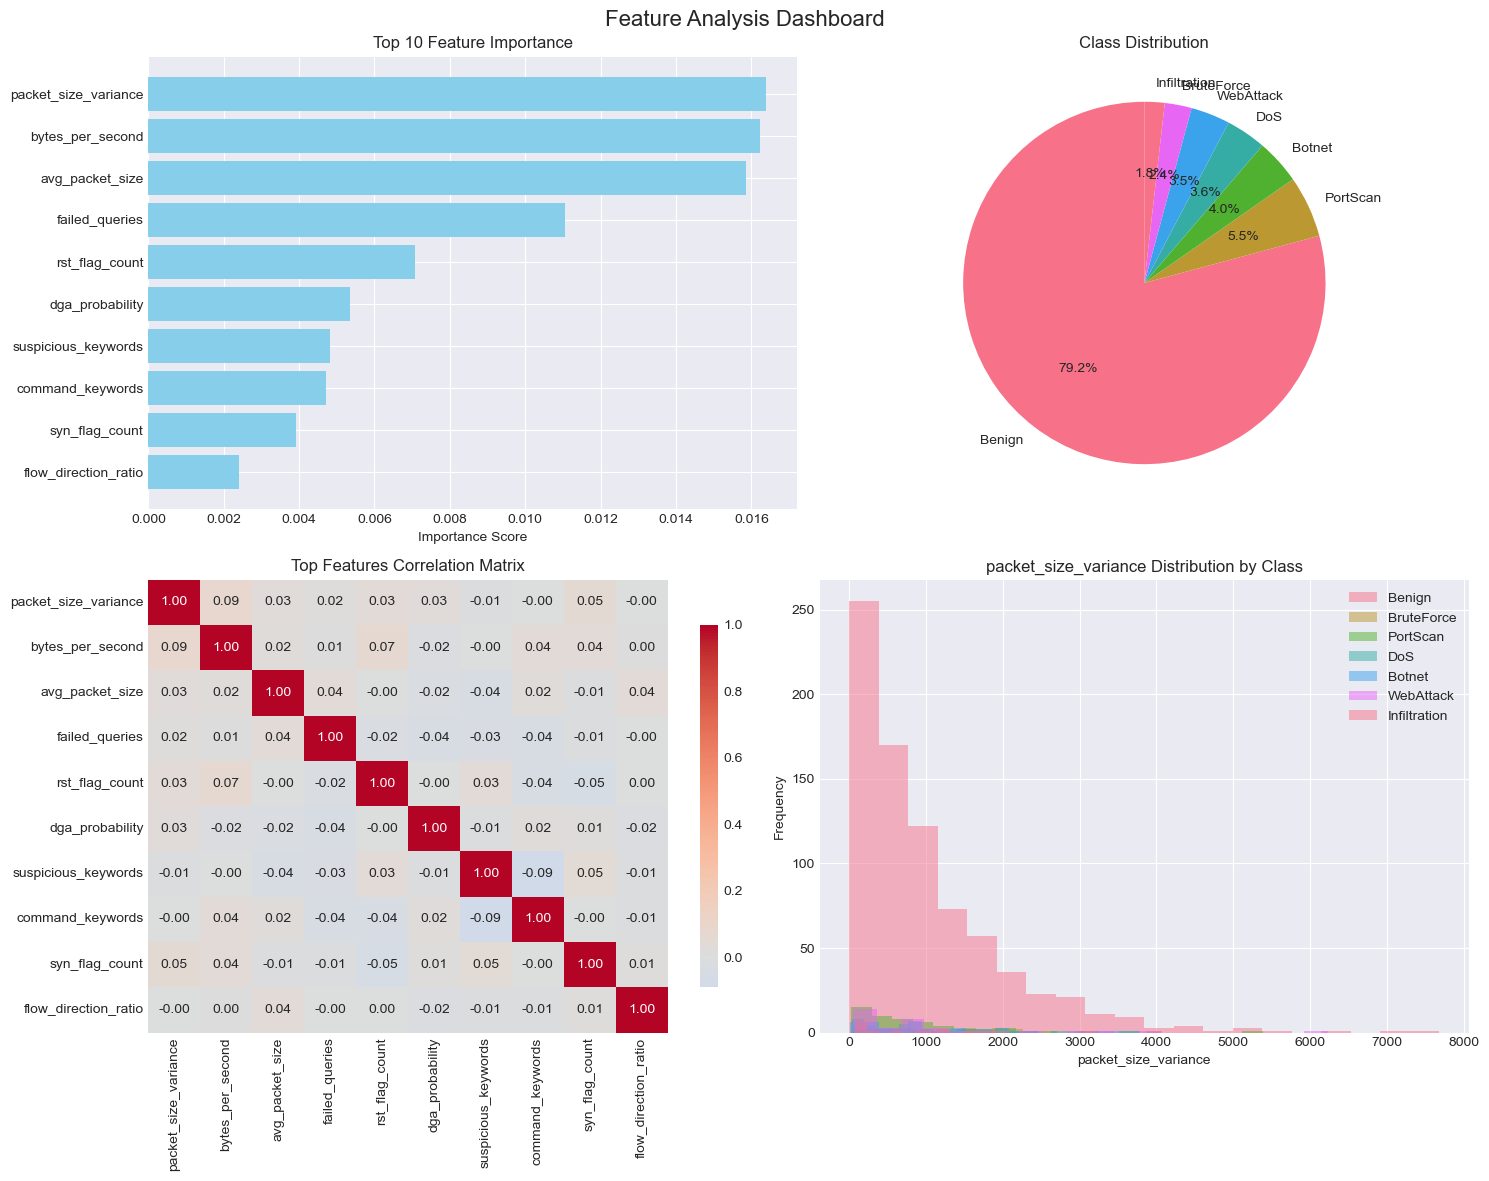


 Step 3: Machine Learning
----------------------------------------
Preparing data for machine learning...
✓ Training set: (800, 17)
✓ Test set: (200, 17)

 Training XGBoost model...

 Error during analysis: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

 Please configure settings in Cell 3 before running the analysis


Traceback (most recent call last):
  File "C:\Users\mmalo\AppData\Local\Temp\ipykernel_20968\2725154194.py", line 49, in run_analysis_pipeline
    ml_pipeline.train_xgboost(X_train, X_test, y_train, y_test)
  File "C:\Users\mmalo\AppData\Local\Temp\ipykernel_20968\1487152002.py", line 69, in train_xgboost
    model.fit(
  File "c:\Users\mmalo\anaconda3\envs\MSc_Project\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'


In [ ]:
# Cell 8: Export and Reporting
"""
Export results and generate reports
"""

class ResultExporter:
    """
    Export analysis results in multiple formats
    """
    
    def __init__(self, config, features_df, models, results):
        self.config = config
        self.features_df = features_df
        self.models = models
        self.results = results
        self.export_dir = Path(config['output_dir'])
        
    def export_all(self):
        """Export all results"""
        
        print("\n" + "="*70)
        print("EXPORTING RESULTS")
        print("="*70)
        
        # Create directories
        (self.export_dir / 'data').mkdir(parents=True, exist_ok=True)
        (self.export_dir / 'models').mkdir(exist_ok=True)
        (self.export_dir / 'reports').mkdir(exist_ok=True)
        
        # Export data
        self._export_data()
        
        # Export models
        self._export_models()
        
        # Generate reports
        self._generate_reports()
        
        print(f"\nAll results exported to: {self.export_dir}")
    
    def _export_data(self):
        """Export processed data"""
        
        print("\nExporting data...")
        
        # CSV format
        csv_path = self.export_dir / 'data' / 'features.csv'
        self.features_df.to_csv(csv_path, index=False)
        print(f"  CSV: {csv_path}")
        
        # HDF5 format for ML
        h5_path = self.export_dir / 'data' / 'features.h5'
        with h5py.File(h5_path, 'w') as f:
            # Store features
            X = self.features_df.drop('label', axis=1).values
            f.create_dataset('features', data=X, dtype='float32')
            
            # Store labels
            le = LabelEncoder()
            y = le.fit_transform(self.features_df['label'])
            f.create_dataset('labels', data=y, dtype='int32')
            
            # Store metadata
            f.attrs['feature_names'] = list(self.features_df.drop('label', axis=1).columns)
            f.attrs['label_names'] = list(le.classes_)
        
        print(f"  HDF5: {h5_path}")
    
    def _export_models(self):
        """Export trained models"""
        
        print("\nExporting models...")
        
        for model_name, model in self.models.items():
            model_path = self.export_dir / 'models' / f'{model_name}.pkl'
            joblib.dump(model, model_path)
            print(f"  {model_name}: {model_path}")
    
    def _generate_reports(self):
        """Generate analysis reports"""
        
        print("\nGenerating reports...")
        
        # Text report
        self._generate_text_report()
        
        # HTML report
        self._generate_html_report()
    
    def _generate_text_report(self):
        """Generate text summary report"""
        
        report_path = self.export_dir / 'reports' / 'summary.txt'
        
        with open(report_path, 'w') as f:
            f.write("NETWORK TRAFFIC ANALYSIS REPORT\n")
            f.write("=" * 70 + "\n\n")
            
            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"PCAP File: {self.config['pcap_file']}\n")
            f.write(f"Analysis Mode: {self.config['analysis_mode']}\n\n")
            
            f.write("DATASET SUMMARY\n")
            f.write("-" * 40 + "\n")
            f.write(f"Total Samples: {len(self.features_df):,}\n")
            f.write(f"Total Features: {len(self.features_df.columns) - 1}\n\n")
            
            f.write("CLASS DISTRIBUTION\n")
            f.write("-" * 40 + "\n")
            for label, count in self.features_df['label'].value_counts().items():
                percentage = (count / len(self.features_df)) * 100
                f.write(f"  {label}: {count:,} ({percentage:.1f}%)\n")
            
            f.write("\nMODEL PERFORMANCE\n")
            f.write("-" * 40 + "\n")
            for model_name, result in self.results.items():
                f.write(f"  {model_name}: {result['accuracy']:.4f} accuracy\n")
            
            # Threat analysis
            threat_count = (self.features_df['label'] != 'Benign').sum()
            threat_percentage = (threat_count / len(self.features_df)) * 100
            
            f.write("\nTHREAT ANALYSIS\n")
            f.write("-" * 40 + "\n")
            f.write(f"Total Threats: {threat_count:,} ({threat_percentage:.1f}%)\n")
            f.write(f"Benign Traffic: {len(self.features_df) - threat_count:,}\n")
        
        print(f"  Text report: {report_path}")
    
    def _generate_html_report(self):
        """Generate HTML report"""
        
        report_path = self.export_dir / 'reports' / 'report.html'
        
        # Calculate metrics
        threat_count = (self.features_df['label'] != 'Benign').sum()
        threat_percentage = (threat_count / len(self.features_df)) * 100
        
        # Build class distribution table
        class_table = ""
        for label, count in self.features_df['label'].value_counts().items():
            percentage = (count / len(self.features_df)) * 100
            class_table += f"<tr><td>{label}</td><td>{count:,}</td><td>{percentage:.1f}%</td></tr>"
        
        # Build model performance table
        model_table = ""
        for model_name, result in self.results.items():
            model_table += f"<tr><td>{model_name}</td><td>{result['accuracy']:.4f}</td></tr>"
        
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Network Traffic Analysis Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; }}
                h1 {{ color: #333; border-bottom: 2px solid #333; }}
                h2 {{ color: #666; }}
                table {{ border-collapse: collapse; width: 100%; margin: 10px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                .metric {{ background-color: #e8f4f8; padding: 10px; margin: 10px 0; }}
                .warning {{ color: #ff6b6b; font-weight: bold; }}
                .success {{ color: #51cf66; font-weight: bold; }}
            </style>
        </head>
        <body>
            <h1>Network Traffic Analysis Report</h1>
            <p>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            
            <h2>Configuration</h2>
            <table>
                <tr><th>Parameter</th><th>Value</th></tr>
                <tr><td>PCAP File</td><td>{self.config['pcap_file']}</td></tr>
                <tr><td>Analysis Mode</td><td>{self.config['analysis_mode']}</td></tr>
                <tr><td>Deep Inspection</td><td>{self.config['deep_inspection']}</td></tr>
            </table>
            
            <h2>Dataset Summary</h2>
            <div class="metric">
                <p>Total Samples: {len(self.features_df):,}</p>
                <p>Total Features: {len(self.features_df.columns) - 1}</p>
                <p>Threat Percentage: <span class="{'warning' if threat_percentage > 10 else 'success'}">{threat_percentage:.1f}%</span></p>
            </div>
            
            <h2>Class Distribution</h2>
            <table>
                <tr><th>Class</th><th>Count</th><th>Percentage</th></tr>
                {class_table}
            </table>
            
            <h2>Model Performance</h2>
            <table>
                <tr><th>Model</th><th>Accuracy</th></tr>
                {model_table}
            </table>
            
            <h2>Recommendations</h2>
            <ul>
                <li>Review flows with high threat scores for manual analysis</li>
                <li>Investigate IPs with multiple attack indicators</li>
                <li>Update firewall rules based on detected patterns</li>
                <li>Monitor for similar attack signatures in real-time</li>
            </ul>
        </body>
        </html>
        """
        
        with open(report_path, 'w') as f:
            f.write(html)
        
        print(f"  HTML report: {report_path}")

# ### Step 9: Main Execution Pipeline

In [ ]:
# Cell 9: Main Execution Pipeline
"""
Main execution cell that runs the complete analysis
"""

def run_analysis_pipeline():
    """
    Main function that executes the complete analysis pipeline
    """
    
    # Check configuration
    if 'CONFIG' not in globals():
        print("Error: Please configure settings first (Cell 2)")
        return None
    
    config = CONFIG
    
    print("\n" + "="*70)
    print("STARTING NETWORK TRAFFIC ANALYSIS PIPELINE")
    print("="*70)
    print(f"\nConfiguration:")
    print(f"  PCAP File: {config['pcap_file']}")
    print(f"  Analysis Mode: {config['analysis_mode']}")
    print(f"  Output Directory: {config['output_dir']}")
    
    start_time = time.time()
    
    try:
        # Step 1: Feature Extraction
        print("\n" + "-"*70)
        print("Step 1: Feature Extraction")
        print("-"*70)
        
        extractor = UnifiedFeatureExtractor(config)
        features_df = extractor.extract_all_features()
        
        if features_df is None or features_df.empty:
            print("Error: No features extracted")
            return None
        
        print(f"\nExtracted {len(features_df)} samples with {len(features_df.columns)} features")
        
        # Step 2: Feature Analysis
        print("\n" + "-"*70)
        print("Step 2: Feature Analysis")
        print("-"*70)
        
        analyzer = FeatureAnalyzer(features_df)
        selected_features = analyzer.analyze_features()
        
        if not selected_features:
            print("Warning: No features selected for ML")
            selected_features = features_df.select_dtypes(include=[np.number]).columns[:20]
        
        # Step 3: Machine Learning
        print("\n" + "-"*70)
        print("Step 3: Machine Learning")
        print("-"*70)
        
        ml_pipeline = MLPipeline(features_df, selected_features, config)
        models, results = ml_pipeline.run_pipeline()
        
        # Step 4: Export Results
        print("\n" + "-"*70)
        print("Step 4: Export Results")
        print("-"*70)
        
        exporter = ResultExporter(config, features_df, models, results)
        exporter.export_all()
        
        # Calculate execution time
        execution_time = time.time() - start_time
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE")
        print("="*70)
        print(f"\nExecution time: {execution_time/60:.1f} minutes")
        print(f"Output directory: {config['output_dir']}")
        
        # Display summary
        threat_count = (features_df['label'] != 'Benign').sum() if 'label' in features_df else 0
        threat_percentage = (threat_count / len(features_df)) * 100 if len(features_df) > 0 else 0
        
        print("\nSummary:")
        print(f"  Total samples: {len(features_df):,}")
        print(f"  Features used: {len(selected_features)}")
        print(f"  Models trained: {len(models)}")
        
        if results:
            best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            print(f"  Best model: {best_model[0]} ({best_model[1]['accuracy']:.4f} accuracy)")
        
        if threat_percentage > 10:
            print(f"\nWARNING: High threat level detected - {threat_percentage:.1f}% malicious traffic")
        elif threat_percentage > 5:
            print(f"\nNOTICE: Moderate threat level - {threat_percentage:.1f}% suspicious traffic")
        else:
            print(f"\nSTATUS: Low threat level - {threat_percentage:.1f}% anomalous traffic")
        
        return {
            'features_df': features_df,
            'models': models,
            'results': results,
            'selected_features': selected_features
        }
    
    except Exception as e:
        print(f"\nError during analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Execute the pipeline
if __name__ == "__main__":
    print("Ready to run analysis. Please ensure configuration is complete in Cell 2.")
    print("Then run: results = run_analysis_pipeline()")

# ### Step 10: Interactive Results Explorer

In [ ]:
# Cell 10: Interactive Results Explorer
"""
Interactive exploration of analysis results
"""

class ResultsExplorer:
    """
    Interactive interface for exploring analysis results
    """
    
    def __init__(self, results_dict):
        if results_dict is None:
            print("No results to explore. Please run the analysis pipeline first.")
            return
            
        self.features_df = results_dict['features_df']
        self.models = results_dict['models']
        self.results = results_dict['results']
        self.selected_features = results_dict['selected_features']
        
        self.setup_ui()
    
    def setup_ui(self):
        """Create interactive widgets for result exploration"""
        
        # Query interface
        self.query_type = widgets.Dropdown(
            options=['Top Threats', 'Specific IP', 'Attack Type', 'Feature Statistics'],
            description='Query Type:',
            style={'description_width': 'initial'}
        )
        
        self.query_input = widgets.Text(
            placeholder='Enter query parameter (e.g., IP address)',
            description='Parameter:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        
        self.query_button = widgets.Button(
            description='Search',
            button_style='primary'
        )
        self.query_button.on_click(self.execute_query)
        
        self.output = widgets.Output()
        
        display(HTML("<h3>Results Explorer</h3>"))
        display(widgets.VBox([
            self.query_type,
            self.query_input,
            self.query_button,
            self.output
        ]))
    
    def execute_query(self, b):
        """Execute user query on results"""
        
        with self.output:
            clear_output()
            
            query_type = self.query_type.value
            
            if query_type == 'Top Threats':
                self.show_top_threats()
            elif query_type == 'Specific IP':
                self.show_ip_analysis(self.query_input.value)
            elif query_type == 'Attack Type':
                self.show_attack_type(self.query_input.value)
            elif query_type == 'Feature Statistics':
                self.show_feature_stats()
    
    def show_top_threats(self):
        """Display top detected threats"""
        
        threats = self.features_df[self.features_df['label'] != 'Benign']
        
        if threats.empty:
            print("No threats detected in the dataset")
            return
        
        print("TOP DETECTED THREATS")
        print("-" * 50)
        
        # Group by source IP
        if 'src_ip' in threats.columns:
            ip_threats = threats.groupby('src_ip').agg({
                'label': 'count',
                'dst_ip': 'nunique'
            }).sort_values('label', ascending=False).head(10)
            
            print("\nTop 10 Source IPs with Threats:")
            for ip, row in ip_threats.iterrows():
                print(f"  {ip}: {row['label']} threats to {row['dst_ip']} unique destinations")
        
        # Attack type distribution
        print("\nAttack Type Distribution:")
        for attack_type, count in threats['label'].value_counts().items():
            print(f"  {attack_type}: {count} instances")
    
    def show_ip_analysis(self, ip_address):
        """Show analysis for specific IP"""
        
        if not ip_address:
            print("Please enter an IP address")
            return
        
        # Find flows involving this IP
        if 'src_ip' in self.features_df.columns and 'dst_ip' in self.features_df.columns:
            ip_flows = self.features_df[
                (self.features_df['src_ip'] == ip_address) | 
                (self.features_df['dst_ip'] == ip_address)
            ]
        else:
            print("IP address columns not found in dataset")
            return
        
        if ip_flows.empty:
            print(f"No flows found for IP: {ip_address}")
            return
        
        print(f"ANALYSIS FOR IP: {ip_address}")
        print("-" * 50)
        print(f"Total flows: {len(ip_flows)}")
        
        # Traffic breakdown
        as_source = (ip_flows['src_ip'] == ip_address).sum() if 'src_ip' in ip_flows else 0
        as_dest = (ip_flows['dst_ip'] == ip_address).sum() if 'dst_ip' in ip_flows else 0
        
        print(f"As source: {as_source}")
        print(f"As destination: {as_dest}")
        
        # Attack classification
        print("\nTraffic Classification:")
        for label, count in ip_flows['label'].value_counts().items():
            percentage = (count / len(ip_flows)) * 100
            print(f"  {label}: {count} ({percentage:.1f}%)")
        
        # Feature averages for this IP
        print("\nKey Feature Averages:")
        for feature in self.selected_features[:5]:
            if feature in ip_flows.columns:
                avg_value = ip_flows[feature].mean()
                print(f"  {feature}: {avg_value:.3f}")
    
    def show_attack_type(self, attack_type):
        """Show details for specific attack type"""
        
        if not attack_type:
            print("Available attack types:")
            for label in self.features_df['label'].unique():
                if label != 'Benign':
                    print(f"  - {label}")
            return
        
        attacks = self.features_df[self.features_df['label'] == attack_type]
        
        if attacks.empty:
            print(f"No instances of attack type: {attack_type}")
            return
        
        print(f"ANALYSIS FOR ATTACK TYPE: {attack_type}")
        print("-" * 50)
        print(f"Total instances: {len(attacks)}")
        
        # Feature patterns
        print("\nCharacteristic Features:")
        for feature in self.selected_features[:10]:
            if feature in attacks.columns:
                mean_attack = attacks[feature].mean()
                mean_benign = self.features_df[self.features_df['label'] == 'Benign'][feature].mean()
                
                if mean_benign > 0:
                    ratio = mean_attack / mean_benign
                    if ratio > 2 or ratio < 0.5:
                        print(f"  {feature}: {ratio:.2f}x compared to benign")
        
        # Source IPs
        if 'src_ip' in attacks.columns:
            print("\nTop Source IPs:")
            for ip, count in attacks['src_ip'].value_counts().head(5).items():
                print(f"  {ip}: {count} attacks")
    
    def show_feature_stats(self):
        """Show feature statistics"""
        
        print("FEATURE STATISTICS")
        print("-" * 50)
        
        for feature in self.selected_features[:10]:
            if feature in self.features_df.columns:
                values = self.features_df[feature]
                
                print(f"\n{feature}:")
                print(f"  Mean: {values.mean():.3f}")
                print(f"  Std: {values.std():.3f}")
                print(f"  Min: {values.min():.3f}")
                print(f"  Max: {values.max():.3f}")

# Usage: After running the pipeline
# explorer = ResultsExplorer(results)

# ### Step 11: Run Complete Analysis

In [ ]:
# Cell 11: Run Complete Analysis
"""
Final execution cell - Run this after configuration
"""

print("="*70)
print("READY TO ANALYZE")
print("="*70)
print("\nInstructions:")
print("1. Ensure configuration is complete in Cell 2")
print("2. Run: results = run_analysis_pipeline()")
print("3. Explore results: explorer = ResultsExplorer(results)")
print("\nThe analysis will:")
print("- Extract flow and semantic features")
print("- Analyze feature importance")
print("- Train ML models")
print("- Export results to specified directory")

# Uncomment to run automatically:
# results = run_analysis_pipeline()
# if results:
#     explorer = ResultsExplorer(results)